## Setup

In [175]:
import os
import torch
import pandas as pd
from torch import nn
from torch.autograd import Variable

In [176]:
# Использовать gpu
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [177]:
!pip install transformers
!apt-get install unzip wget -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [178]:
PATH_TO_DISK = '/content/drive'

In [179]:
from google.colab import drive
drive.mount(PATH_TO_DISK)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download pretrained model and pretrained tokenizer

In [180]:
PATH_TO_MODEL = os.path.join(PATH_TO_DISK, 'My Drive', 'Colab Notebooks/15_epoch_simple_lstm_100.pt')

PATH_TO_PRETRAINED_TOKENIZER = 'sberbank-ai/sbert_large_nlu_ru'

In [181]:
# Загрузить sbertTokenizer
from transformers import AutoTokenizer, AutoModel

sbertTokenizer = AutoTokenizer.from_pretrained(PATH_TO_PRETRAINED_TOKENIZER)

In [182]:
import torch.nn as nn
import torch.nn.functional as F

# Класс дистиллированной модели-ученика, которую мы будем файнтюнить.
# Нужно скопировать из тетрадки, в которой модель дистиллировалась
class SimpleLSTM(nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, batch_size, device=None):
        super(SimpleLSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.device = self.init_device(device)
        self.hidden = self.init_hidden()

    @staticmethod
    def init_device(device):
        if device is None:
            return torch.device('cuda')
        return device

    def init_hidden(self):
        return (Variable(torch.zeros(2 * self.n_layers, self.batch_size, self.hidden_dim).to(self.device)),
                Variable(torch.zeros(2 * self.n_layers, self.batch_size, self.hidden_dim).to(self.device)))

    def forward(self, text, text_lengths=None):
        self.hidden = self.init_hidden()
        x = self.embedding(text)
        x, self.hidden = self.rnn(x, self.hidden)
        hidden, cell = self.hidden
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        x = self.fc(hidden)

        return x

In [183]:
# Загружаем дистиллированную модель. Все параметры должны быть перенесены из тетрадки с дистилляцией.
modelParameters = {'input_dim' : sbertTokenizer.vocab_size,
                   'embedding_dim' : 50,
                   'hidden_dim' : 256,
                   'output_dim' : 1024,
                   'n_layers' : 2,
                   'bidirectional' : True,
                   'dropout' : 0.2,
                   'batch_size' : 32}

model = SimpleLSTM(
            input_dim = modelParameters['input_dim'],
            embedding_dim = modelParameters['embedding_dim'],
            hidden_dim = modelParameters['hidden_dim'],
            output_dim = modelParameters['output_dim'],
            n_layers = modelParameters['n_layers'],
            bidirectional = modelParameters['bidirectional'],
            dropout = modelParameters['dropout'],
            batch_size = modelParameters['batch_size'])

model.load_state_dict(torch.load(PATH_TO_MODEL))

# Переносим модель на GPU
model.to(device)

SimpleLSTM(
  (embedding): Embedding(120138, 50)
  (rnn): LSTM(50, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1024, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [184]:
# Проверим, что модель правильно загрузилась
tokenized_sent = sbertTokenizer(['Инфляция - жуткая штука'] *32 , padding=True, truncation=True, max_length=20)
inds = torch.tensor(tokenized_sent['input_ids'])
inds_cuda = inds.to(device)
model.eval()
model(inds_cuda.t(), None)

tensor([[ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997],
        [ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997],
        [ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997],
        ...,
        [ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997],
        [ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997],
        [ 0.9378, -0.1869, -0.5879,  ...,  0.1863,  0.5791,  0.5997]],
       device='cuda:0', grad_fn=<AddmmBackward>)

# Prepare data


In [185]:
# Путь к файлу с данными в .csv формате.
# Здесь мы используем датасет Lenta.ru
PATH_TO_DATA = os.path.join(PATH_TO_DISK, 'My Drive', 'Colab Notebooks/test-lenta.csv')

# Если данные в .zip файле, предварительно их нужно распаковать и указать путь на распакованный .csv-файл
# !unzip -o PATH_TO_DATA
# PATH_TO_DATA = ...

TOKENIZER_MAX_LENGHT = 20

In [186]:
def getPreparedDataFromCSV(path, max_lenght):
    '''
    Принимает:  path - путь к .csv файлу с данными
                max_lenght - параметр для токенизатора
    Выдает:     input_ids - токенизированные предложения, torch.tensor
                labels - класссы каждого предложения, которые мы должны научиться предсказывать, torch.tensor
                id_to_topic - соответствие классов и реальных меток, list
    '''
    data = pd.read_csv(path)

    topic_to_id = {}
    id_to_topic = []
    for topic in data.topic:
        if not topic in topic_to_id:
            topic_to_id[topic] = len(id_to_topic)
            id_to_topic.append(topic)

    labels = []
    for topic in data.topic:
        labels.append(topic_to_id[topic])
    
    input_ids = [] # encoded sentences

    for sent in data.title:
        encoded_input = sbertTokenizer(sent, padding='max_length',
                                       truncation=True,
                                       max_length=max_lenght,
                                       return_tensors='pt')
        input_ids.append(encoded_input['input_ids'])

    input_ids = torch.cat(input_ids, dim=0)
    labels = torch.tensor(labels)

    return input_ids, labels, id_to_topic

In [187]:
# Прочитаем данные из файла и рандомно разобьем их на датасеты
# в отношении 7 : 2 : 1 для train : validation : test

from torch.utils.data import TensorDataset, random_split

input_ids, labels, id_to_topic = getPreparedDataFromCSV(PATH_TO_DATA, TOKENIZER_MAX_LENGHT)
dataset = TensorDataset(input_ids, labels)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} testing samples'.format(test_size))

35,000 training samples
10,000 validation samples
5,000 testing samples


# Train model

In [188]:
trainingParameters = {
    'optimizer' : {
        'lr' : 2e-5,
        'eps' : 1e-8
    },
    'epochs' : 30,
    'batch_size' : modelParameters['batch_size']
}

In [189]:
# Создадим DataLoader для каждого датасета

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = trainingParameters['batch_size']

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

testing_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [190]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = trainingParameters['optimizer']['lr'],
                  eps = trainingParameters['optimizer']['eps']
                )


In [191]:
from transformers import get_linear_schedule_with_warmup

epochs = trainingParameters['epochs']

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [192]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [193]:
# Инициализируем модель, которую будем тренировать
# Здесь можно поиграть с количеством слоев и внутренних параметров
# Я пробовала один линейный слой и число внутренних параметров (512, 512), (1024, 512), (512, 128)

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(p=0.1)
        self.lin1 = nn.Linear(1024, 512)
        self.lin2 = nn.Linear(512, 256)
        self.lin3 = nn.Linear(256, len(id_to_topic))

    def forward(self, x, text_lengths=None):
        x = self.model(x.t(), text_lengths=text_lengths).squeeze(1)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [194]:
net = Net()
net.to(device)

Net(
  (model): SimpleLSTM(
    (embedding): Embedding(120138, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
)

In [195]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

criterion = nn.CrossEntropyLoss()

# We'll store validation loss, validation accuracy, and timings.
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    net.train()

    for step, batch in enumerate(train_dataloader):

        if len(batch[0]) != batch_size:
            continue

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].cuda()
        b_labels = batch[1].cuda()

        net.zero_grad()
        optimizer.zero_grad()  

        result = net(b_input_ids)

        loss = criterion(result, b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

        del b_input_ids
        del b_labels
        torch.cuda.empty_cache()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # Validation

    print("")
    print("Running Validation...")

    t0 = time.time()

    net.eval()

    total = 0
    correct = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        if len(batch[0]) != batch_size:
            continue
    
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)


        with torch.no_grad():        
            result = net(b_input_ids)

        loss = criterion(result, b_labels)
            
        total_eval_loss += loss.item()

        label_ids = b_labels.to('cpu').numpy()

        _, predicted = torch.max(result.data, 1)
        total += b_labels.size(0)
        correct += (predicted == b_labels).sum().item()

        del b_input_ids
        del b_labels
        torch.cuda.empty_cache()
        


    avg_val_accuracy = correct / total
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...
  Batch    40  of  1,094.    Elapsed: 0:00:01.
  Batch    80  of  1,094.    Elapsed: 0:00:01.
  Batch   120  of  1,094.    Elapsed: 0:00:01.
  Batch   160  of  1,094.    Elapsed: 0:00:02.
  Batch   200  of  1,094.    Elapsed: 0:00:02.
  Batch   240  of  1,094.    Elapsed: 0:00:03.
  Batch   280  of  1,094.    Elapsed: 0:00:03.
  Batch   320  of  1,094.    Elapsed: 0:00:04.
  Batch   360  of  1,094.    Elapsed: 0:00:04.
  Batch   400  of  1,094.    Elapsed: 0:00:05.
  Batch   440  of  1,094.    Elapsed: 0:00:05.
  Batch   480  of  1,094.    Elapsed: 0:00:06.
  Batch   520  of  1,094.    Elapsed: 0:00:06.
  Batch   560  of  1,094.    Elapsed: 0:00:07.
  Batch   600  of  1,094.    Elapsed: 0:00:07.
  Batch   640  of  1,094.    Elapsed: 0:00:08.
  Batch   680  of  1,094.    Elapsed: 0:00:08.
  Batch   720  of  1,094.    Elapsed: 0:00:09.
  Batch   760  of  1,094.    Elapsed: 0:00:09.
  Batch   800  of  1,094.    Elapsed: 0:00:09.
  Batch   840  o

## Display statictics

In [196]:
import pandas as pd

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df = df_stats.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.25,2.14,0.34,0:00:13,0:00:01
2,1.99,1.75,0.47,0:00:13,0:00:01
3,1.68,1.53,0.52,0:00:13,0:00:01
4,1.50,1.42,0.54,0:00:13,0:00:01
5,1.40,1.36,0.56,0:00:13,0:00:01
6,1.33,1.31,0.57,0:00:13,0:00:01
7,1.28,1.27,0.59,0:00:13,0:00:01
8,1.24,1.25,0.59,0:00:13,0:00:01
9,1.21,1.23,0.60,0:00:13,0:00:01


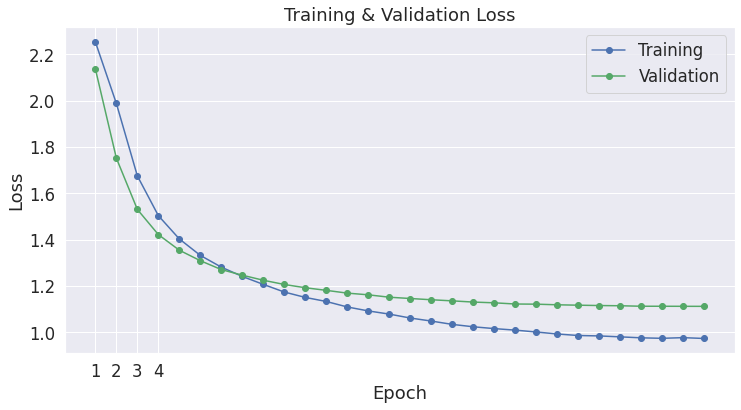

In [197]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Testing

In [198]:
net.eval()

predictions , true_labels = [], []

print()
print('Testing...')

for (step, batch) in enumerate(testing_dataloader):

    batch = tuple(t.to(device) for t in batch)

    if len(batch[0]) != batch_size:
            continue
    
    if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(testing_dataloader)))

    b_input_ids, b_labels = batch

    with torch.no_grad():
        result = net(b_input_ids)

    label_ids = b_labels.to('cpu').numpy()

    _, predicted = torch.max(result.data, 1)

    predictions.append(predicted)
    true_labels.append(label_ids)

    del b_input_ids
    del b_labels
    torch.cuda.empty_cache()

print('DONE.')


Testing...
  Batch    40  of    157.
  Batch    80  of    157.
  Batch   120  of    157.
DONE.


In [199]:
from sklearn.metrics import precision_score, recall_score, f1_score

predicted_labels = np.concatenate([np.array(prediction.to('cpu'), dtype='long') for prediction in predictions])

y_true = np.concatenate(true_labels).flatten()
y_pred = predicted_labels.flatten()

print("Precision: {0:.4f}".format(precision_score(y_true, y_pred, average='macro'))) # unweighted average of precisions
print("Recall: {0:.4f}".format(recall_score(y_true, y_pred, average='macro'))) # unweighted average of recalls
print("F1-score: {0:.4f}".format(f1_score(y_true, y_pred, average='macro'))) # unweighted average of f1-scores

Precision: 0.6394
Recall: 0.6378
F1-score: 0.6376


# Save model

In [200]:
OUTPUT_DIR = os.path.join(PATH_TO_DISK, 'My Drive')
MODEL_NAME_TO_SAVE = 'distilled-model'
PARAMETERS_NAME_TO_SAVE = 'args-distilled-model.bin'

In [201]:
# Save model, tokenizer and training arguments
torch.save(net.state_dict(), os.path.join(OUTPUT_DIR, MODEL_NAME_TO_SAVE))
sbertTokenizer.save_pretrained(OUTPUT_DIR)
torch.save(trainingParameters, os.path.join(OUTPUT_DIR, PARAMETERS_NAME_TO_SAVE))

Look at the sizes, out of curiousity

In [202]:
output_dir = './model_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

torch.save(net.state_dict(), os.path.join(output_dir, MODEL_NAME_TO_SAVE))
sbertTokenizer.save_pretrained(output_dir)
torch.save(trainingParameters, os.path.join(output_dir, PARAMETERS_NAME_TO_SAVE))

!ls -l --block-size=K ./model_save/

total 41164K
-rw-r--r-- 1 root root     1K May 27 14:30 args-distilled-model.bin
-rw-r--r-- 1 root root 36719K May 27 14:30 distilled-model
-rw-r--r-- 1 root root     1K May 27 14:30 special_tokens_map.json
-rw-r--r-- 1 root root     1K May 27 14:30 tokenizer_config.json
-rw-r--r-- 1 root root  2689K May 27 14:30 tokenizer.json
-rw-r--r-- 1 root root  1739K May 27 14:30 vocab.txt


To load model from drive:

In [203]:
from transformers import BertTokenizerFast

# Net class must be the same as class of the saved model. Initialize it somewehere before
model = Net()

model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, MODEL_NAME_TO_SAVE)))
tokenizer = BertTokenizerFast.from_pretrained(OUTPUT_DIR)

# Copy the model to the GPU.
model.to(device)

Net(
  (model): SimpleLSTM(
    (embedding): Embedding(120138, 50)
    (rnn): LSTM(50, 256, num_layers=2, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
)

Done :)